The parameter for LSTM in this file is based on Thara, S., & Poornachandran, P. (2022). Social media text analytics of Malayalam–English code-mixed using deep learning. Journal of big Data, 9(1), 45.

In [ ]:
pip install tensorflow numpy pandas scikit-learn seaborn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Change the name of the train file and test file
df = pd.read_csv('SMOTE Train Part 2 MESocSentiment.csv')
df2 = pd.read_csv('Test Part 2 Ground Truth.csv')

In [ ]:
df.head()

,Tweets,Sentiment (All)
0,dost karde bamszlk g kutluyoruz happy malaysia...,POSITIVE
1,malaysia face vietnam group b aff cup,NEUTRAL
2,whitebrowed crake poliolimnas cinereus baram w...,NEUTRAL
3,burmese pool taiping perak malaysia vivo x pro...,NEUTRAL
4,no comments penang malayasia,NEUTRAL


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10863 entries, 0 to 10862
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tweets           10863 non-null  object
 1   Sentiment (All)  10863 non-null  object
dtypes: object(2)
memory usage: 169.9+ KB


In [ ]:
df.shape

(10863, 2)

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in the tweet (using the highest value for maximum sequence length in the paper)
MAX_SEQUENCE_LENGTH = 16
# using the lowest word embedding dimension from the paper
EMBEDDING_DIM = 100

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df['Tweets'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15346 unique tokens.


In [ ]:
X_train = tokenizer.texts_to_sequences(df['Tweets'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (10863, 16)


In [ ]:
Y_train = pd.get_dummies(df['Sentiment (All)']).values
print('Shape of label tensor:', Y_train.shape)

Shape of label tensor: (10863, 3)


In [ ]:
df2.head()

,Tweets,Sentiment (MESocSentiment),Sentiment (Manual)
0,new post pocketimes youtube abang,NEUTRAL,NEUTRAL
1,merdeka motherfuckers,NEUTRAL,NEGATIVE
2,waiting bunga api kalau ada hahahah,NEUTRAL,NEUTRAL
3,random pics places kl took using ig filters se...,NEUTRAL,POSITIVE
4,kim pangon malaysia try new players chiangmai,NEUTRAL,NEUTRAL


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Tweets                      2000 non-null   object
 1   Sentiment (MESocSentiment)  2000 non-null   object
 2   Sentiment (Manual)          2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


In [ ]:
df2.drop(['Sentiment (MESocSentiment)'], axis = 1, inplace = True)
df2.head(100)

,Tweets,Sentiment (Manual)
0,new post pocketimes youtube abang,NEUTRAL
1,merdeka motherfuckers,NEGATIVE
2,waiting bunga api kalau ada hahahah,NEUTRAL
3,random pics places kl took using ig filters se...,POSITIVE
4,kim pangon malaysia try new players chiangmai,NEUTRAL
...,...,...
95,kahwin siam kahwin aggregate,NEUTRAL
96,kitar teliti ventures east roadone tyres,NEUTRAL
97,mano polking admit gol gol perlawanan ikut spe...,NEUTRAL
98,hiring data analyst intern lumpur,NEUTRAL


In [ ]:
df2.shape

(2000, 2)

In [ ]:
df2.value_counts("Sentiment (Manual)")

,count
Sentiment (Manual),
NEUTRAL,1386
NEGATIVE,388
POSITIVE,226


In [ ]:
tokenizer.fit_on_texts(df2['Tweets'].values)
word_index2 = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index2))

Found 19783 unique tokens.


In [ ]:
X_test = tokenizer.texts_to_sequences(df2['Tweets'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (2000, 16)


In [ ]:
Y_test = pd.get_dummies(df2['Sentiment (Manual)']).values
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (2000, 3)


In [ ]:
Y_test

array([[False,  True, False],
       [ True, False, False],
       [False,  True, False],
       ...,
       [False,  True, False],
       [False,  True, False],
       [False,  True, False]])

In [ ]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(10863, 16) (10863, 3)
(2000, 16) (2000, 3)


In [ ]:
#Define the model
model = Sequential()

#Define embedding layer
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))

# Add a 1D Spatial Dropout layer
model.add(tensorflow.keras.layers.SpatialDropout1D(rate=0.5))# using 0.5 value because the paper stated the used parameters is 0 to 1

# Add a LSTM layer with tanh activation
model.add(LSTM(units=130, activation='tanh'))#hidden units (80-150) and activation used are from the paper

# Add a Dropout layer
model.add(Dropout(rate=0.5))# using 0.5 value because the paper stated the used parameters is 0 to 1

#Add feedforward neural network layer for classification
model.add(Dense(3, activation='softmax')) #units are from number of classes and activation is based on paper

#Compiling the model
#optimizer are from the paper
#The paper only state that using cross-entropy, but the code using the specific categorical_crossentropy instead
#Using accuracy for metrics
#learning rate is using default learning rate
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#using early stopping to stop training where there is no improvement in loss in 3 consecutive epochs

callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
# Train the model
#batch size and epoch are from the smallest values used in the paper
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=32,callbacks=[callback])

Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step - accuracy: 0.6273 - loss: 0.7680 - val_accuracy: 0.4420 - val_loss: 1.9422
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 29s 86ms/step - accuracy: 0.9621 - loss: 0.1114 - val_accuracy: 0.4085 - val_loss: 2.1151
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.9906 - loss: 0.0355 - val_accuracy: 0.3710 - val_loss: 3.3634
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 30s 89ms/step - accuracy: 0.9963 - loss: 0.0154 - val_accuracy: 0.4070 - val_loss: 3.0435
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.9970 - loss: 0.0104 - val_accuracy: 0.3885 - val_loss: 3.5852
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - accuracy: 0.9987 - loss: 0.0060 - val_accuracy: 0.4045 - val_loss: 3.7675
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.4015 - val_loss: 3.2613
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9995 - loss: 0.0027 - 

In [ ]:
history.history

{'accuracy': [0.7889165282249451,
  0.9655712246894836,
  0.9892295002937317,
  0.9953972101211548,
  0.9975144863128662,
  0.9985271096229553,
  0.998158872127533,
  0.9989873766899109,
  0.9990794658660889,
  0.9988953471183777],
 'loss': [0.4954324960708618,
  0.10179929435253143,
  0.03819408640265465,
  0.017858002334833145,
  0.009487210772931576,
  0.007137017790228128,
  0.006203860975801945,
  0.003992551937699318,
  0.0033848644234240055,
  0.004471530206501484],
 'val_accuracy': [0.44200000166893005,
  0.40849998593330383,
  0.3709999918937683,
  0.40700000524520874,
  0.38850000500679016,
  0.40450000762939453,
  0.40149998664855957,
  0.36250001192092896,
  0.33799999952316284,
  0.36250001192092896],
 'val_loss': [1.942210078239441,
  2.115051746368408,
  3.363401412963867,
  3.0434534549713135,
  3.585219621658325,
  3.7674508094787598,
  3.2613258361816406,
  3.930647373199463,
  4.529375076293945,
  4.466256141662598]}

In [ ]:
#saving the model in HD5 format
from tensorflow.keras.models import load_model, save_model

# Assuming 'model' is your TensorFlow model
model.save('lstm 1 july 2024 model.h5')

from google.colab import files
files.download('lstm 1 july 2024 model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Test accuracy: {accuracy}')
print(f'Test accuracy: {accuracy:.3f}')
print(f'Test accuracy: {accuracy:.4f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3922 - loss: 4.2003
Test accuracy: 36.25%
Test accuracy: 0.36250001192092896
Test accuracy: 0.363
Test accuracy: 0.3625


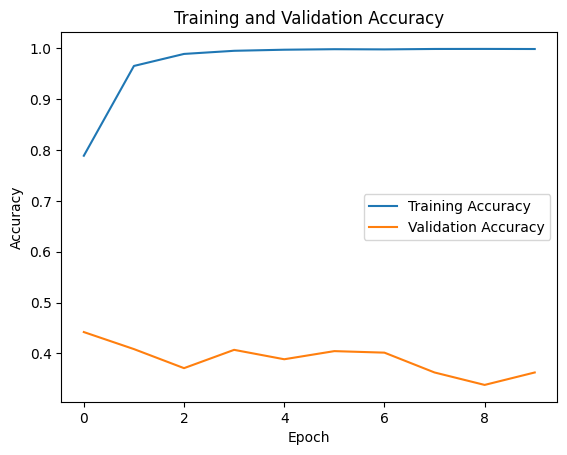

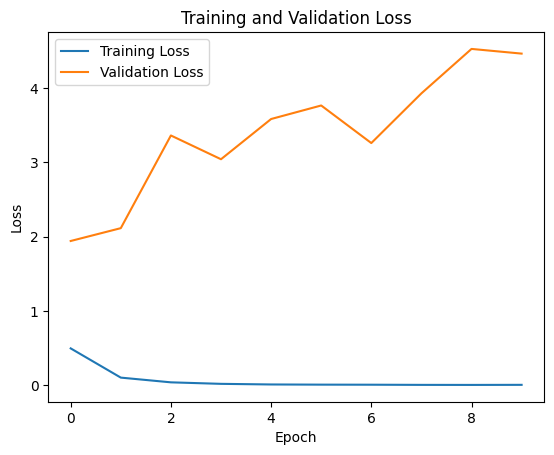

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

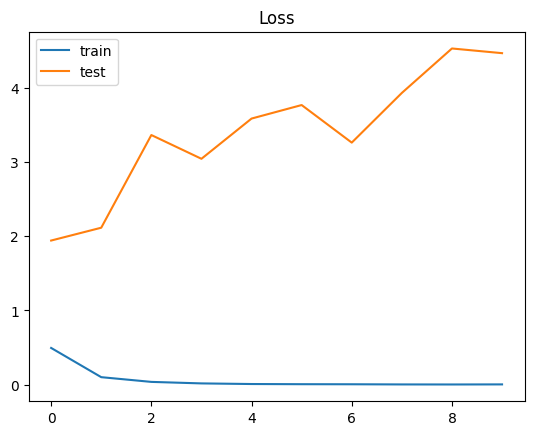

In [ ]:
#Graph for loss
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

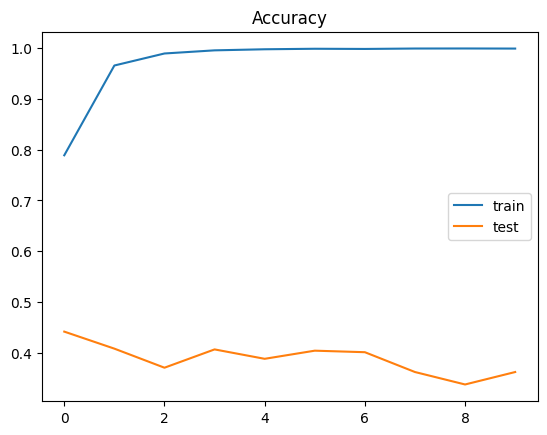

In [ ]:
#Graph for accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
#Prediction
predictions_LSTM = model.predict(X_test)
test_prediction_LSTM = pd.DataFrame()
test_prediction_LSTM['Tweets'] = df2['Tweets']

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
classes = np.argmax(predictions_LSTM, axis=1)
print(classes)

[2 1 0 ... 0 0 0]


In [ ]:
test_prediction_LSTM['Classes'] = classes

In [ ]:
#import numpy as np

labels = ['NEGATIVE', 'POSITIVE', 'NEUTRAL']
sentiment = [labels[idx] for idx in np.argmax(predictions_LSTM, axis=1)]
print(sentiment)

['NEUTRAL', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEUTRAL', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEUTRAL', 'POSITIVE', 'NEUTRAL', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEUTRAL', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEUTRAL', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEUTRAL', 'NEGATIVE', 'NEUTRAL', 'NEGATIVE', 'NEUTRAL', 'NEUTRAL', 'POSITIVE', 'NEUTRAL', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEUTRAL', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEUTRAL', 'NEGATIVE', 'NEUTRAL', 'NEGATIVE', 'NEUTRAL', 'POSITIVE', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEGATIVE', 'NEGATIVE', 'NEUTRAL', 'NEGATIVE', 'NEGATIVE', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEGATIVE', 'NEUTRAL', 'POSITIVE', 'NEGATIVE', 'NE

In [ ]:
test_prediction_LSTM['Sentiment'] = sentiment

In [ ]:
test_prediction_LSTM

,Tweets,Classes,Sentiment
0,new post pocketimes youtube abang,2,NEUTRAL
1,merdeka motherfuckers,1,POSITIVE
2,waiting bunga api kalau ada hahahah,0,NEGATIVE
3,random pics places kl took using ig filters se...,1,POSITIVE
4,kim pangon malaysia try new players chiangmai,1,POSITIVE
...,...,...,...
1995,geng sila hadirkan diri padananpembelian full ...,2,NEUTRAL
1996,terlalu top bosses senior managers berpeluang ...,2,NEUTRAL
1997,geng hadirkan diri jika masuk market korang na...,0,NEGATIVE
1998,berani duludulu bawa masuk coin tu jekredit twt,0,NEGATIVE


In [ ]:
#Change the name of the output file
test_prediction_LSTM.to_csv(r"16August2024_LSTM_TestPart2_test_prediction.csv")

In [ ]:
import pandas as pd

value_counts = test_prediction_LSTM['Sentiment'].value_counts()

print(value_counts)

Sentiment
NEGATIVE    942
POSITIVE    580
NEUTRAL     478
Name: count, dtype: int64


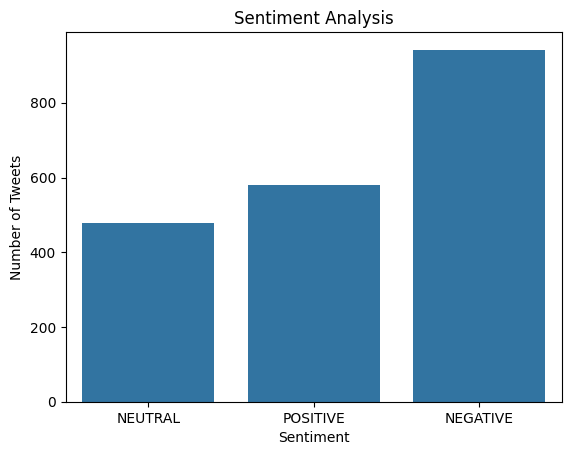

In [ ]:
#create bar graph
import matplotlib.pyplot as plt
import seaborn as sns

# create a barplot
sns.countplot(x='Sentiment', data= test_prediction_LSTM)

# set the title
plt.title('Sentiment Analysis')

# set the x and y label
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')

# show the plot
plt.show()

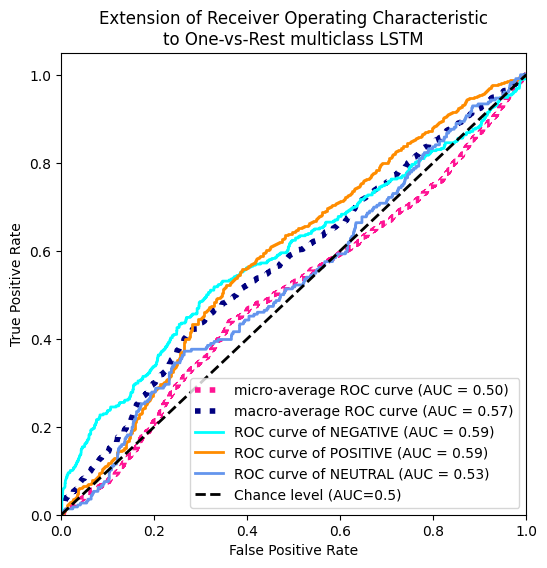

In [ ]:
#AUC-ROC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Calculate ROC AUC for each class
n_classes = predictions_LSTM.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predictions_LSTM[:, i])
    roc_auc[i] = roc_auc_score(Y_test[:, i], predictions_LSTM[:, i])

# Compute microaverage ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predictions_LSTM.ravel())
roc_auc["micro"] = roc_auc_score(Y_test, predictions_LSTM, average="micro")

# Compute macroaverage ROC AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = roc_auc_score(Y_test, predictions_LSTM, average="macro")

# Class labels
labels = ['NEGATIVE', 'POSITIVE', 'NEUTRAL']

# Plot ROC curves
fig, ax = plt.subplots(figsize=(6, 6))

# Plot microaverage ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot macroaverage ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curves for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {labels[i]} (AUC = {roc_auc[i]:.2f})')

# Plot random classifier (chance level)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2, label='Chance level (AUC=0.5)')

# Plot chance value annotation
#plt.plot([0, 1], [0.5, 0.5], color='red', linestyle='-.', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass LSTM')
plt.legend(loc="lower right")
plt.show()


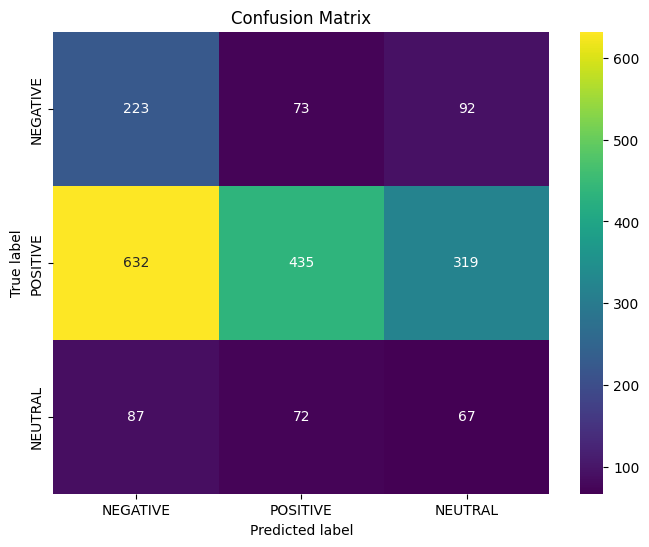

In [ ]:
#Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming predictions_LSTM is your LSTM model's predictions and Y_test is your true labels
predictions = np.argmax(predictions_LSTM, axis=1)

# Define your class labels
labels = ['NEGATIVE', 'POSITIVE', 'NEUTRAL']

# Convert predicted and true labels to sentiment labels
predicted_sentiment = [labels[idx] for idx in predictions]
true_sentiment = [labels[idx] for idx in np.argmax(Y_test, axis=1)]

# Compute confusion matrix
conf_mat = confusion_matrix(true_sentiment, predicted_sentiment, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#Classification Report

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Assuming df2 has your tweets and Y_test has your actual labels
# Assuming Y_test is one-hot encoded
y_pred = np.argmax(predictions_LSTM, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Generate classification report
class_names = ['NEGATIVE', 'POSITIVE', 'NEUTRAL']  # Replace with your actual class names
report = classification_report(y_true, y_pred, target_names=class_names)

print(report)



              precision    recall  f1-score   support

    NEGATIVE       0.24      0.57      0.34       388
    POSITIVE       0.75      0.31      0.44      1386
     NEUTRAL       0.14      0.30      0.19       226

    accuracy                           0.36      2000
   macro avg       0.38      0.40      0.32      2000
weighted avg       0.58      0.36      0.39      2000

